In [46]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Load data
X_full, y_full = load_svmlight_file("/kaggle/input/optimization-covtype/covtype.libsvm.binary.scale")
print('y_full unique values (after load):', np.unique(y_full)) 

# convert to ±1
y_full = np.where(y_full == 1, 1, -1)
y_orig_full = y_full.copy()   # ±1

# convert to {0,1} for cross-entropy (convex)
y_full_01 = (y_full == 1).astype(int)

# Shuffle
X_full, y_full_01, y_orig_full = shuffle(X_full, y_full_01, y_orig_full, random_state=42)

# Split
X_train, X_test, y_train, y_test, y_orig_train, y_orig_test = train_test_split(
    X_full, y_full_01, y_orig_full, test_size=0.2, random_state=42, stratify=y_full_01
)

ypm_train = y_orig_train.copy()    # ±1
ypm_test  = y_orig_test.copy()     # ±1


print("ypm_test unique:", np.unique(ypm_test))
print("Test set label ratio: positive =", np.mean(ypm_test == 1), ", negative =", np.mean(ypm_test == -1))


y_full unique values (after load): [1. 2.]
ypm_test unique: [-1  1]
Test set label ratio: positive = 0.5124050153610492 , negative = 0.4875949846389508


In [47]:
import numpy as np
import time



EPOCHS = 5
ITER_PER_EPOCH = X_train.shape[1]
MAX_ITER = EPOCHS * ITER_PER_EPOCH

print(f"Feature dim (d)     : {ITER_PER_EPOCH}")
print(f"Epochs              : {EPOCHS}")
print(f"Total max_iter      : {MAX_ITER}")

lambda_reg = 1e-4

def logistic_loss(X, y, w, lambda_reg=lambda_reg): 
    """
    Compute logistic regression loss with L2 regularization:
        f(w) = (1/n) * Σ log(1 + exp(-y_i * x_i^T w)) + (λ/2) * ||w||^2
    This loss is smooth and becomes λ-strongly convex when λ > 0.
    """
    n_samples = X.shape[0]
    z = X @ w
    probs = 1 / (1 + np.exp(-z))
    data_loss = -np.mean(y * np.log(probs + 1e-12)
                         + (1 - y) * np.log(1 - probs + 1e-12))
    reg = 0.5 * lambda_reg * np.dot(w, w)
    return data_loss + reg  

def logistic_full_grad(X, y, w, lambda_reg=lambda_reg):
    """
    Full gradient of logistic + L2:
        ∇f = (1/n) Xᵀ(σ(Xw) - y) + λ w
    """
    n_samples = X.shape[0]
    z = X @ w
    probs = 1 / (1 + np.exp(-z))
    grad_data = X.T @ (probs - y) / n_samples
    return grad_data + lambda_reg * w


def logistic_grad_i(X, y, w, i, lambda_reg=lambda_reg):
    """
    Coordinate i partial derivative of logistic + L2:
        ∂f/∂w_i = (1/n) Σ_j x_{j,i} (σ(x_j·w)-y_j) + λ w_i
    """
    n_samples = X.shape[0]
    z = X @ w
    probs = 1 / (1 + np.exp(-z))
    grad_i = X[:, i].T @ (probs - y) / n_samples
    return grad_i + lambda_reg * w[i]

def compute_accuracy(X, y, w):
    """
    Compute classification accuracy for logistic model:
      predict = 1{σ(Xw) ≥ 0.5}
    """
    probs = 1 / (1 + np.exp(-X @ w))
    preds = (probs >= 0.5).astype(int)
    return np.mean(preds == y)


def compute_Ls(X, lambda_reg=lambda_reg):
    """
    Estimate per-coordinate Lipschitz constants for logistic loss + L2:
        L_i ≈ (||X[:, i]||^2) / (4 * n_samples) + λ
    Supports both dense arrays and CSR sparse matrices.
    """
    n_samples = X.shape[0]
    # element-wise square and sum over samples
    if hasattr(X, "multiply"):
        # for CSR matrix, use multiply for element-wise square
        squared_sums = np.asarray(X.multiply(X).sum(axis=0)).ravel()
    else:
        # for dense array
        squared_sums = np.sum(X**2, axis=0)
    base_L = squared_sums / (4 * n_samples)
    return base_L + lambda_reg


def timed_gradient_descent(*args, **kwargs):
    t0 = time.time()
    w, obj_values = gradient_descent(*args, **kwargs)
    return w, obj_values, time.time() - t0
    
def timed_rcd_single(X, y, loss_grad_i, Ls, alpha, **kwargs):
    t0 = time.time()
    w, obj_values = randomized_coordinate_descent(
        X, y, loss_grad_i, Ls, alpha=alpha, **kwargs
    )
    return w, obj_values, time.time() - t0
    
def timed_rcd(X, y, loss_grad_i, Ls, alphas, **kwargs):
    times = {}
    histories = {}
    for alpha in alphas:
        t0 = time.time()
        _, obj_values = randomized_coordinate_descent(
            X, y, loss_grad_i, Ls, alpha=alpha, **kwargs)
        histories[alpha] = obj_values
        times[alpha] = time.time() - t0
    return histories, times

def timed_acd(*args, **kwargs):
    t0 = time.time()
    w, obj_values, _ = acd(*args, **kwargs)
    return w, obj_values, time.time() - t0


def gradient_descent(X, y, loss_full_grad, loss_fn, L,
                     max_iter=MAX_ITER, x0=None, return_path=False):
    n_samples, n_features = X.shape
    x = np.zeros(n_features) if x0 is None else x0.copy()
    obj_values = [loss_fn(X, y, x)]
    path = [x.copy()] if return_path else None
    for _ in range(max_iter):
        grad = loss_full_grad(X, y, x)
        x -= grad / L
        obj_values.append(loss_fn(X, y, x))
        if return_path:
            path.append(x.copy())
    if return_path:
        return x, obj_values, path
    return x, obj_values

def randomized_coordinate_descent(
    X, y, loss_grad_i, Ls,
    alpha=1.0, loss_fn=logistic_loss,
    max_iter=MAX_ITER, x0=None,
    return_path=False   
):
    n_samples, n_features = X.shape
    x = np.zeros(n_features) if x0 is None else x0.copy()
    obj_values = [loss_fn(X, y, x)]
    path = [x.copy()] if return_path else None   
    weights = Ls**alpha
    p = weights / weights.sum()
    for _ in range(max_iter):
        i = np.random.choice(n_features, p=p)
        gi = loss_grad_i(X, y, x, i)
        x[i] -= gi / Ls[i]
        obj_values.append(loss_fn(X, y, x))
        if return_path:
            path.append(x.copy())
    if return_path:
        return x, obj_values, path
    return x, obj_values


def acd(X, y, num_iters=MAX_ITER, lambda_reg=lambda_reg,sigma=None, Li=None, loss_fn=logistic_loss):
    n, d = X.shape
    if sigma is None:
        sigma = lambda_reg
    if Li    is None: 
        Li    = compute_Ls(X, lambda_reg)

    x = np.zeros(d)
    v = np.zeros(d)
    a = 0.5
    b = 1.0

    obj_values = []
    x_history  = []
    
    for it in range(num_iters):
        # (1) compute gamma from old a,b
        B     = (sigma/d)*(a**2/b**2) - 1.0/d
        C     = -(a**2/b**2)
        gamma = (-B + np.sqrt(B*B - 4*C)) / 2
    
        # (2) compute beta
        beta  = 1 - gamma*sigma/d
    
        # (3) compute alpha and yk using old x,v
        alpha = (d - gamma*sigma) / (gamma*(d*d - sigma))
        yk    = alpha*v + (1-alpha)*x
    
        # (4) coordinate update to get new x,v
        i      = np.random.randint(d)
        gi     = logistic_grad_i(X, y, yk, i, lambda_reg)
        x_new  = yk.copy();   x_new[i] -= gi / Li[i]
        v_new  = beta*v + (1-beta)*yk
        v_new[i] -= (gamma / Li[i]) * gi
    
        # (5) now update b,a using beta_k
        b      = b / np.sqrt(beta)
        a      = gamma * b
    
        # (6) commit x,v and record loss
        x, v   = x_new, v_new
        obj_values.append(loss_fn(X, y, x))
        x_history.append(x.copy())

    return x, obj_values, x_history

def nonconvex_regularizer(w, lambda_, alpha):
    return lambda_ * np.sum((alpha * w**2) / (1 + alpha * w**2))

def logistic_loss_nonconvex(X, y, w, lambda_=0.001, alpha=1.0):
    """
    data_loss = (1/n) Σ log(1 + exp(−y_i·(x_i·w)))
    """
    n = X.shape[0]
    z = X @ w
    data_loss = np.mean(np.log(1 + np.exp(-y * z)))
    reg = nonconvex_regularizer(w, lambda_, alpha)
    return data_loss + reg

def logistic_grad_i_nonconvex(X, y, w, i, lambda_=0.001, alpha=1.0):
    n = X.shape[0]
    z = X @ w
    sigma_neg = 1 / (1 + np.exp(y * z))
    # data term on coordinate i, faster sparse dot
    grad_data = - (X[:, i].T @ (y * sigma_neg)) / n
    reg_grad  = 2 * lambda_ * alpha * w[i] / (1 + alpha * w[i]**2)**2
    return grad_data + reg_grad


def logistic_full_grad_nonconvex(X, y, w, lambda_=0.001, alpha=1.0):
    n = X.shape[0]
    z = X @ w
    sigma_neg = 1 / (1 + np.exp(y * z))
    grad_data = - (X.T @ (y * sigma_neg)) / n
    reg_grad  = 2 * lambda_ * alpha * w / (1 + alpha * w**2)**2
    return grad_data + reg_grad


def compute_accuracy_pm(X, y_pm, w):
    """
    Compute accuracy for y in {-1,1} logistic:
      predict = sign(Xw) in {-1,1}
    """
    preds = np.sign(X @ w)
    return np.mean(preds == y_pm)


print("Cell 2 complete: all functions loaded")


Feature dim (d)     : 54
Epochs              : 5
Total max_iter      : 270
Cell 2 complete: all functions loaded


Ls percentiles: [1.07571067e-06 6.75546300e-05 2.17185984e-04 5.63726176e-03
 7.77088140e-02 1.94743052e-01]


/tmp/ipykernel_36/3633888973.py:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] -= gi / Ls[i]


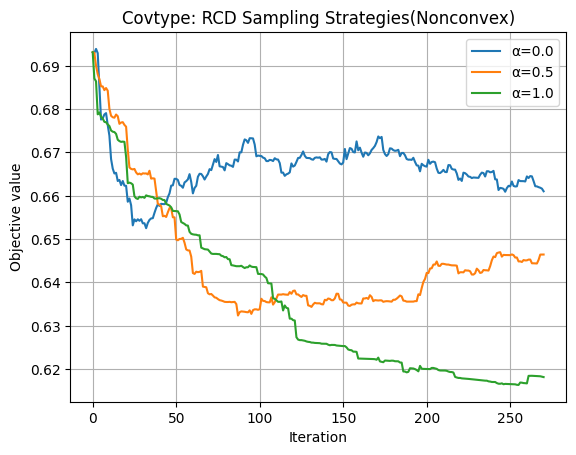

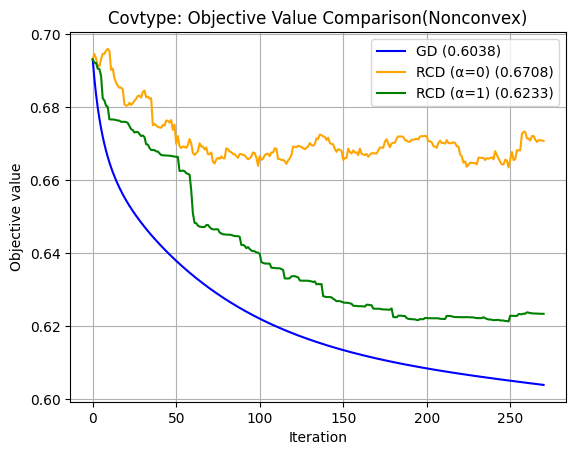

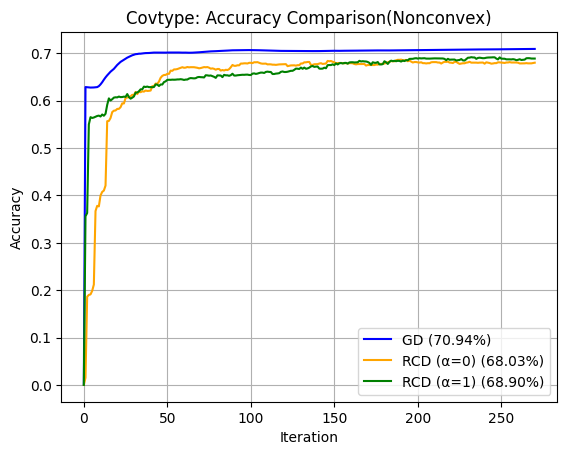

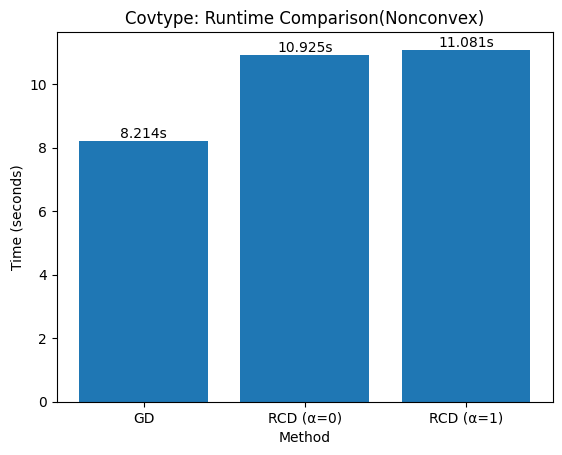

In [48]:
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from functools import partial


num_runs = 3
max_iter = 270
alphas   = [0.0, 0.5, 1.0]
lambda_nc = 0.003
alpha_nc  = 5

# Compute per-coordinate Lipschitz constants
Ls = compute_Ls(X_train, lambda_reg=0.0)   
print("Ls percentiles:", np.percentile(Ls, [0,5,10,50,90,100]))

Ls = np.maximum(Ls, 0.0015)



grad_i_nc = partial(logistic_grad_i_nonconvex,
                    lambda_=lambda_nc,
                    alpha=alpha_nc)
loss_nc   = partial(logistic_loss_nonconvex,
                    lambda_=lambda_nc,
                    alpha=alpha_nc)


# --- 1A: RCD Sampling Strategies (Nonconvex) ---
plt.figure()
for a in alphas:
    all_runs = []
    for _ in range(num_runs):
        _, vals = randomized_coordinate_descent(
            X_train, ypm_train,
            loss_grad_i=grad_i_nc,
            Ls=Ls,
            alpha=a,
            loss_fn=loss_nc,
            max_iter=max_iter,
        )
        all_runs.append(vals)
    plt.plot(np.mean(all_runs, axis=0), label=f"α={a}")

plt.xlabel("Iteration")
plt.ylabel("Objective value")
plt.title("Covtype: RCD Sampling Strategies(Nonconvex)")
plt.legend()
plt.grid(True)
plt.savefig("covtype_rcd_sampling_Nonconvex.png", dpi=300, bbox_inches='tight')
plt.show()


# --- 2A: Objective Value Comparison (Nonconvex) ---
from scipy.sparse.linalg import svds

# estimate data-term full Lipschitz constant
u, s, _   = svds(X_train, k=1)
sigma_max = s[0]
n_samples = X_train.shape[0]
L_full    = (sigma_max**2) / (4 * n_samples)

gd_vals, rcd0_vals, rcd1_vals = [], [], []

for _ in range(num_runs):
    # GD
    _, gd_obj = gradient_descent(
        X_train, ypm_train,
        lambda X, y, w: logistic_full_grad_nonconvex(X, y, w, lambda_nc, alpha_nc),
        lambda X, y, w: logistic_loss_nonconvex(X, y, w, lambda_nc, alpha_nc),
        L_full, max_iter=max_iter
    )

    # RCD (α=0)
    _, rcd0_obj = randomized_coordinate_descent(
        X_train, ypm_train,
        lambda X, y, w, i: logistic_grad_i_nonconvex(X, y, w, i, lambda_nc, alpha_nc),
        Ls, alpha=0.0,
        loss_fn=lambda X, y, w: logistic_loss_nonconvex(X, y, w, lambda_nc, alpha_nc),
        max_iter=max_iter,
    )

    # RCD (α=1)
    _, rcd1_obj = randomized_coordinate_descent(
        X_train, ypm_train,
        lambda X, y, w, i: logistic_grad_i_nonconvex(X, y, w, i, lambda_nc, alpha_nc),
        Ls, alpha=1.0,
        loss_fn=lambda X, y, w: logistic_loss_nonconvex(X, y, w, lambda_nc, alpha_nc),
        max_iter=max_iter
    ) 
    gd_vals.append(gd_obj)
    rcd0_vals.append(rcd0_obj)
    rcd1_vals.append(rcd1_obj)

gd_vals   = np.vstack(gd_vals)
rcd0_vals = np.vstack(rcd0_vals)
rcd1_vals = np.vstack(rcd1_vals)

plt.figure()
for vals, name, color in zip(
    [gd_vals, rcd0_vals, rcd1_vals],
    ["GD", "RCD (α=0)", "RCD (α=1)"],
    ['blue','orange','green']
):
    mean = vals.mean(axis=0)
    last = float(mean[-1])
    plt.plot(mean, label=f"{name} ({last:.4f})", color=color)

plt.xlabel("Iteration")
plt.ylabel("Objective value")
plt.title("Covtype: Objective Value Comparison(Nonconvex)")
plt.legend()
plt.grid(True)
plt.savefig("covtype_objective_comparison_Nonconvex.png", dpi=300, bbox_inches='tight')
plt.show()

# --- 3A: Accuracy vs Iteration (Nonconvex) ---
acc_gd_all, acc_rcd0_all, acc_rcd1_all = [], [], []

for _ in range(num_runs):
    # GD
    _, _, gd_path = gradient_descent(
        X_train, ypm_train,
        lambda X, y, w: logistic_full_grad_nonconvex(X, y, w, lambda_nc, alpha_nc),
        lambda X, y, w: logistic_loss_nonconvex(X, y, w, lambda_nc, alpha_nc),
        L_full, max_iter=max_iter,
        return_path=True     
    )
    acc_gd = [compute_accuracy_pm(X_test, ypm_test, w) for w in gd_path]
    acc_gd_all.append(acc_gd)

    # RCD (α=0)：
    _, _, rcd0_path = randomized_coordinate_descent(
        X_train, ypm_train,
        lambda X, y, w, i: logistic_grad_i_nonconvex(X, y, w, i, lambda_nc, alpha_nc),
        Ls, alpha=0.0,
        loss_fn=lambda X, y, w: logistic_loss_nonconvex(X, y, w, lambda_nc, alpha_nc),
        max_iter=max_iter,
        return_path=True
    )
    acc_rcd0 = [compute_accuracy_pm(X_test, ypm_test, w) for w in rcd0_path]
    acc_rcd0_all.append(acc_rcd0)

    # RCD (α=1)：
    _, _, rcd1_path = randomized_coordinate_descent(
        X_train, ypm_train,
        lambda X, y, w, i: logistic_grad_i_nonconvex(X, y, w, i, lambda_nc, alpha_nc),
        Ls, alpha=1.0,
        loss_fn=lambda X, y, w: logistic_loss_nonconvex(X, y, w, lambda_nc, alpha_nc),
        max_iter=max_iter,
        return_path=True
    )
    acc_rcd1 = [compute_accuracy_pm(X_test, ypm_test, w) for w in rcd1_path]
    acc_rcd1_all.append(acc_rcd1)

# numpy array
acc_gd_all   = np.array(acc_gd_all)
acc_rcd0_all = np.array(acc_rcd0_all)
acc_rcd1_all = np.array(acc_rcd1_all)

plt.figure()
for acc_vals, name, color in zip(
    [acc_gd_all, acc_rcd0_all, acc_rcd1_all],
    ["GD", "RCD (α=0)", "RCD (α=1)"],
    ['blue', 'orange', 'green']
):
    mean = acc_vals.mean(axis=0)
    plt.plot(mean, label=f"{name} ({mean[-1]*100:.2f}%)", color=color)

plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Covtype: Accuracy Comparison(Nonconvex)")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("covtype_accuracy_vs_iteration_Nonconvex.png", dpi=300, bbox_inches='tight')
plt.show()

# --- 4A: Runtime Comparison (Nonconvex) ---
times = {"GD": [], "RCD (α=0)": [], "RCD (α=1)": []}
for _ in range(num_runs):
    start = time.time()
    gradient_descent(
        X_train, ypm_train,
        loss_full_grad=lambda X, y, w: logistic_full_grad_nonconvex(X, y, w, lambda_nc, alpha_nc),
        loss_fn=lambda X, y, w: logistic_loss_nonconvex(X, y, w, lambda_nc, alpha_nc),
        L=L_full,
        max_iter=max_iter
    )
    times["GD"].append(time.time() - start)

    start = time.time()
    randomized_coordinate_descent(
        X_train, ypm_train,
        loss_grad_i=lambda X, y, w, i: logistic_grad_i_nonconvex(X, y, w, i, lambda_nc, alpha_nc),
        Ls=Ls,
        alpha=0.0,
        loss_fn=lambda X, y, w: logistic_loss_nonconvex(X, y, w, lambda_nc, alpha_nc),
        max_iter=max_iter
    )
    times["RCD (α=0)"].append(time.time() - start)

    start = time.time()
    randomized_coordinate_descent(
        X_train, ypm_train,
        loss_grad_i=lambda X, y, w, i: logistic_grad_i_nonconvex(X, y, w, i, lambda_nc, alpha_nc),
        Ls=Ls,
        alpha=1.0,
        loss_fn=lambda X, y, w: logistic_loss_nonconvex(X, y, w, lambda_nc, alpha_nc),
        max_iter=max_iter
    )
    times["RCD (α=1)"].append(time.time() - start)

plt.figure()
methods = list(times.keys())
mean_times = [np.mean(times[m]) for m in methods]
bars = plt.bar(methods, mean_times)
plt.xlabel("Method")
plt.ylabel("Time (seconds)")
plt.title("Covtype: Runtime Comparison(Nonconvex)")
for bar, t in zip(bars, mean_times):
    plt.text(bar.get_x() + bar.get_width()/2, t + 0.001, f"{t:.3f}s", ha="center", va="bottom")
plt.savefig("covtype_runtime_comparison_Nonconvex.png", dpi=300, bbox_inches='tight')
plt.show()
